In [1]:
import pandas as pd

df = pd.read_pickle("df_reduced.pkl")
df.head()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg
0,balder,01062021-25,0,0.0,1.0,"[[-11.354838709677423, 2.516129032258064], [-1...",21
1,balder,01062021-25,0,0.0,3.0,"[[-32.243697478991606, -0.6134453781512619], [...",12
2,balder,01062021-25,0,0.0,4.0,"[[3.5581395348837077, 9.0], [3.558139534883707...",21
3,balder,01062021-25,0,0.0,6.0,"[[23.952941176470574, 1.7176470588235304], [22...",45
4,balder,01062021-25,0,0.0,7.0,"[[2.2413793103448256, -1.6896551724137936], [1...",11


In [2]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from sklearn.cluster import KMeans
import ast

def fourier_descriptors(trajectory):
    # Assuming the trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Apply Fourier Transform
    fd_x = fft(x)
    fd_y = fft(y)

    # Combine the descriptors and return
    return np.concatenate([np.abs(fd_x), np.abs(fd_y)])

In [3]:
from scipy.interpolate import interp1d

def interpolate_trajectory(trajectory, num_points=50):
    # Assuming trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Create an interpolation function
    length = len(trajectory)
    f_x = interp1d(np.linspace(0, 1, length), x, kind='linear')
    f_y = interp1d(np.linspace(0, 1, length), y, kind='linear')

    # Interpolate to a common number of points
    new_x = f_x(np.linspace(0, 1, num_points))
    new_y = f_y(np.linspace(0, 1, num_points))

    return np.column_stack((new_x, new_y))

In [4]:
df['interpolated_traj'] = df['centered_traj'].apply(interpolate_trajectory)
df['fourier_descriptors'] = df['interpolated_traj'].apply(fourier_descriptors)

In [5]:
# Extracting the Fourier Descriptors as features for clustering
features = np.stack(df['fourier_descriptors'].values)

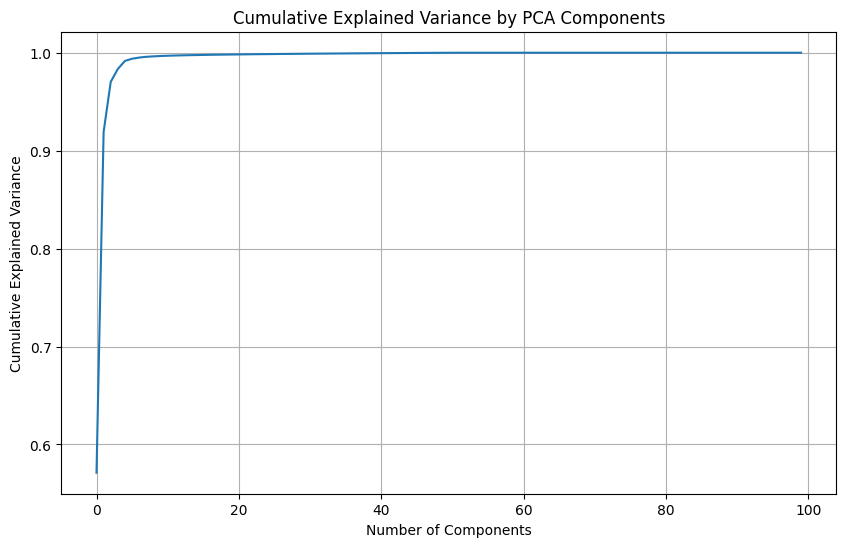

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA without specifying the number of components
pca = PCA()

# Fit PCA on the features
pca.fit(features)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [9]:
cumulative_explained_variance

array([0.57117838, 0.919174  , 0.97028937, 0.9834488 , 0.99163949,
       0.99385701, 0.99506354, 0.9958278 , 0.99628937, 0.99666489,
       0.99691911, 0.99714599, 0.99732439, 0.99748666, 0.9976242 ,
       0.99775219, 0.99786879, 0.99797537, 0.99807715, 0.99817223,
       0.99826473, 0.99835155, 0.99843322, 0.99851138, 0.99858779,
       0.99866079, 0.99873239, 0.99880348, 0.99886988, 0.99893516,
       0.99899869, 0.99906007, 0.9991196 , 0.999178  , 0.99923615,
       0.99929128, 0.99934584, 0.99939858, 0.99945095, 0.99950151,
       0.99955126, 0.99959984, 0.99964742, 0.99969369, 0.99973937,
       0.99978451, 0.99982809, 0.9998707 , 0.99991136, 0.99995095,
       0.99997871, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [13]:
from sklearn.decomposition import PCA

# Number of components to keep
n_components = 2 # You can adjust this based on your needs

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA on features and transform the features
reduced_features = pca.fit_transform(features)

# Now you can use reduced_features for your clustering

In [14]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# List to store the cohesion values for each number of clusters
cluster_cohesion = []
n_clusters = [n for n in range(2,10)]

for n in tqdm(n_clusters, desc="Computing Clusters"):    # Perform hierarchical clustering
    hac = AgglomerativeClustering(n_clusters=n)
    labels = hac.fit_predict(reduced_features)

    # Calculate pairwise distances
    distances = squareform(pdist(reduced_features))

    # Compute average distance within each cluster
    avg_distance_within_cluster = np.mean([
        np.mean([
            distances[i, j] for i in range(len(reduced_features)) if labels[i] == k
                             for j in range(len(reduced_features)) if labels[j] == k and i != j
        ]) for k in range(n)
    ])
    
    cluster_cohesion.append(avg_distance_within_cluster)

    # Store the cluster labels in your dataframe
    df['HAC_cluster_' + str(n)] = labels

# The list 'cluster_cohesion' contains the average distance within clusters for each n


Computing Clusters: 100%|██████████| 8/8 [07:31<00:00, 56.44s/it]


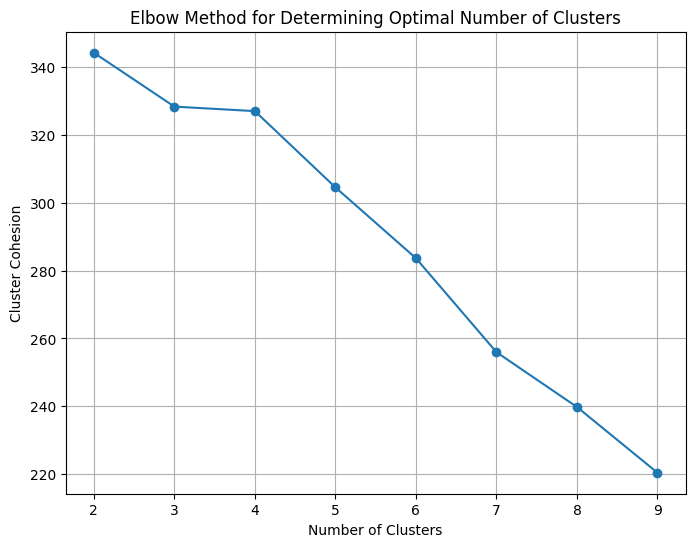

In [15]:
import matplotlib.pyplot as plt

n_clusters = range(2, 10)  # Number of clusters from 2 to 9

plt.figure(figsize=(8, 6))
plt.plot(n_clusters, cluster_cohesion, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Cohesion')
plt.xticks(n_clusters)
plt.grid(True)
plt.show()


In [16]:
cluster_cohesion

[344.26336551742395,
 328.3684039326046,
 327.03719039419497,
 304.55875770189834,
 283.6515137334017,
 255.94659823853894,
 239.764876613519,
 220.37895418772837]

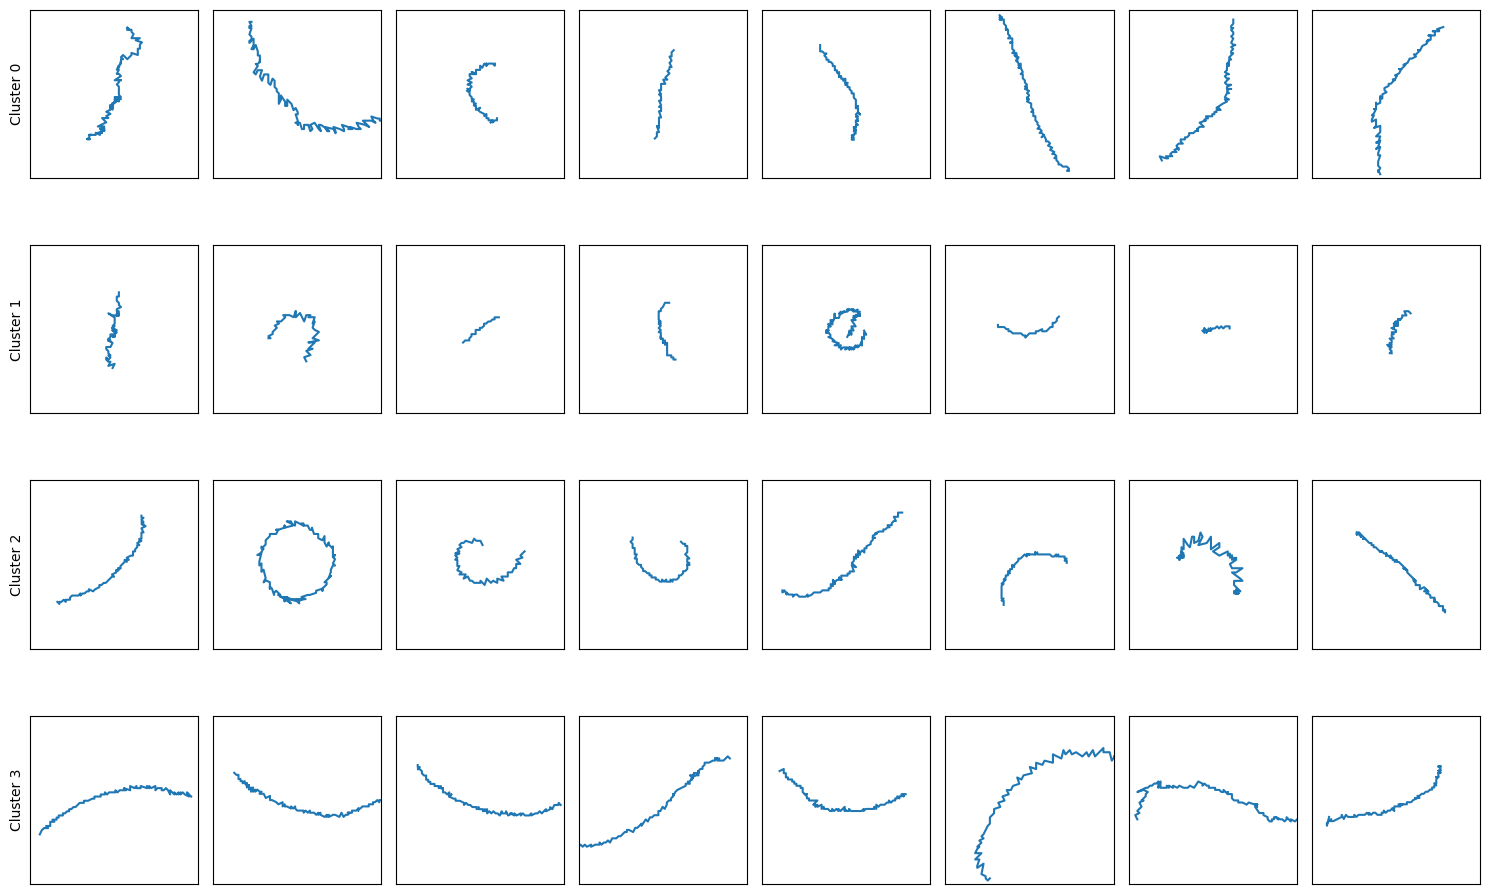

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast


# Number of clusters and samples per cluster

n_samples = 8
num_c = 4 # Based on the elbow. 5 clusters are also reasonables.
# Create a figure with subplots
fig, axes = plt.subplots(num_c, n_samples, figsize=(15, 10))  # Adjust the size as needed

for i in range(num_c):
    # Select random samples from each cluster
    cluster_data = df[df['HAC_cluster_4'] == i].sample(n=n_samples, random_state=42)
    
    for j, (index, row) in enumerate(cluster_data.iterrows()):
        ax = axes[i][j]
        # Extract the centered trajectory
        traj_array = np.array(row['centered_traj'])
        # Plot the trajectory
        ax.plot(traj_array[:, 0], traj_array[:, 1])

        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.set_aspect('equal', adjustable='box')

        # Optional: Hide x and y axis labels for clarity
        ax.set_xticks([])
        ax.set_yticks([])

    # Set y-axis label for each row
    axes[i][0].set_ylabel(f"Cluster {i}")

# Optional: adjust layout for better spacing
plt.tight_layout()
plt.show()

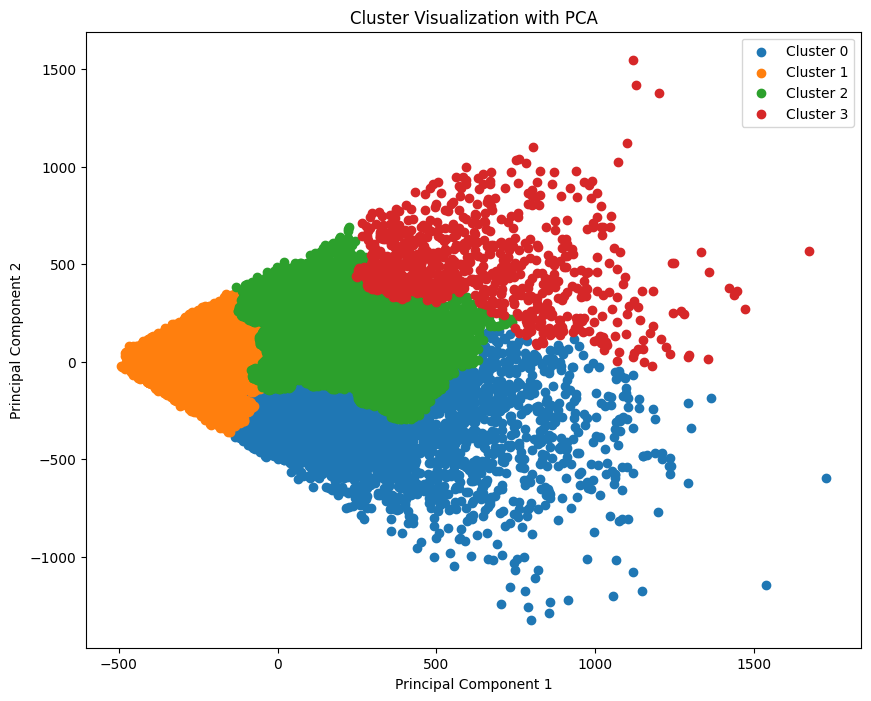

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'features' are your motility parameters
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(4):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['HAC_cluster_'+str(num_c)] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


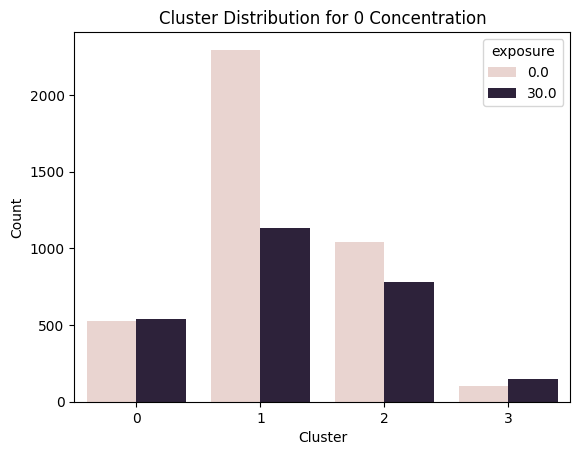

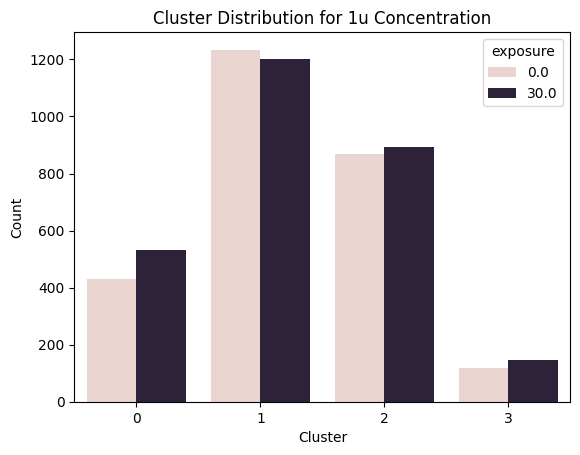

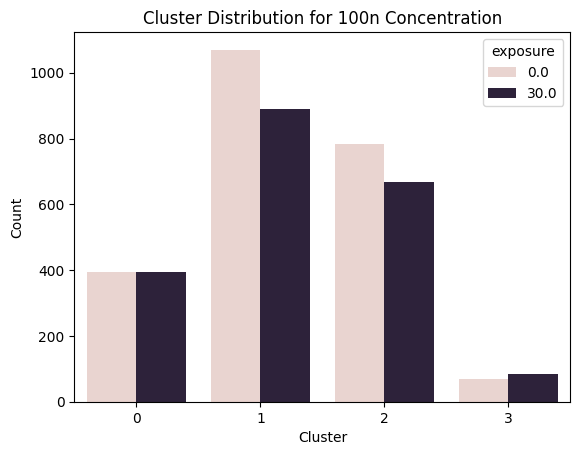

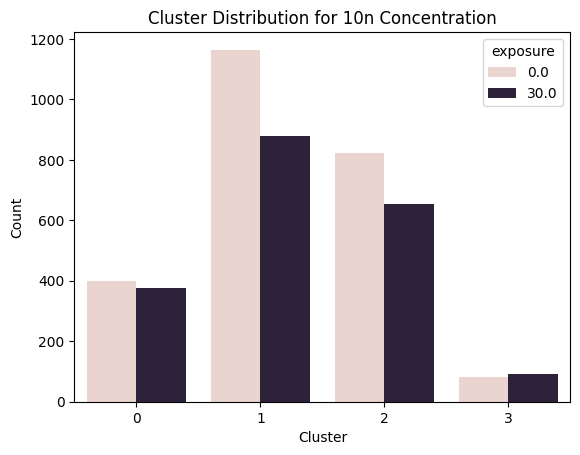

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Distribution of clusters at different time points for each concentration
def plot_cluster_distribution(df):
    for concentration in df['quantity'].unique():
        subset = df[df['quantity'] == concentration]
        sns.countplot(x='HAC_cluster_'+str(num_c), hue='exposure', data=subset)
        plt.title(f'Cluster Distribution for {concentration} Concentration')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

plot_cluster_distribution(df)

In [21]:
master_df = pd.read_pickle("/home/rodriguez/Documents/my_codes/trajectory/master_08052022.pkl")
motility_param = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']
for param in motility_param:
    df[param] = master_df[param]
df.sample()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg,interpolated_traj,fourier_descriptors,HAC_cluster_2,...,HAC_cluster_7,HAC_cluster_8,HAC_cluster_9,VCL,VAP,VSL,LIN,STR,WOB,BeatCross
4586,balder,10032020-62,10n,30.0,192.0,"[[-3.944444444444457, -4.055555555555557], [-3...",42,"[[-3.944444444444457, -4.055555555555557], [-3...","[0.6507936507942866, 97.55824729599831, 33.242...",1,...,0,0,8,61.459343,34.464935,32.97699,0.536566,0.956827,0.560776,36.363636


In [22]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming your dataframe is named 'df'
# df = pd.read_csv('your_dataset.csv') # Uncomment and modify this line if you're reading from a CSV file

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']

# ANOVA for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster_'+str(num_c)].unique():
    cluster_data = df[df['HAC_cluster_'+str(num_c)] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        model = ols(f'{param} ~ C(quantity) * C(exposure)', data=cluster_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param}:')
        print(result)
        print()  # Adding a blank line for better readability

ANOVA results for Cluster 1:
ANOVA for VCL:
                               sum_sq      df           F        PR(>F)
C(quantity)              8.590284e+04     3.0   36.755210  1.299212e-23
C(exposure)              2.052545e+05     1.0  263.466477  1.720492e-58
C(quantity):C(exposure)  3.729910e+04     3.0   15.959148  2.390519e-10
Residual                 7.681469e+06  9860.0         NaN           NaN

ANOVA for VAP:
                               sum_sq      df          F        PR(>F)
C(quantity)              2.248066e+04     3.0  27.617105  8.885595e-18
C(exposure)              8.790646e+03     1.0  32.397476  1.292400e-08
C(quantity):C(exposure)  9.921081e+03     3.0  12.187878  5.876373e-08
Residual                 2.675387e+06  9860.0        NaN           NaN

ANOVA for VSL:
                               sum_sq      df          F        PR(>F)
C(quantity)              7.411690e+03     3.0  10.420850  7.660152e-07
C(exposure)              4.683201e+03     1.0  19.753769  8.904996e